# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
list(range(490, 500))

[490, 491, 492, 493, 494, 495, 496, 497, 498, 499]

In [3]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [4]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.351094
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *Fill this in*
因为是纯随机取的权重，所以计算得到的每一类别的得分因该是差不多的，接近1/N，这里就是0.1，所以损失就接近-log(0.1)了


In [8]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -0.420111 analytic: -0.420111, relative error: 2.367118e-07
numerical: 2.024311 analytic: 2.024311, relative error: 1.531624e-08
numerical: 1.312643 analytic: 1.312643, relative error: 1.715999e-08
numerical: -3.800574 analytic: -3.800574, relative error: 1.793554e-08
numerical: -0.078609 analytic: -0.078610, relative error: 5.312431e-07
numerical: -1.378337 analytic: -1.378337, relative error: 1.843476e-08
numerical: -4.060030 analytic: -4.060030, relative error: 1.624987e-08
numerical: 1.731711 analytic: 1.731711, relative error: 1.710850e-08
numerical: 0.321094 analytic: 0.321094, relative error: 7.241980e-08
numerical: -1.444224 analytic: -1.444224, relative error: 1.316633e-08
numerical: -2.136807 analytic: -2.136807, relative error: 3.036717e-08
numerical: -0.110185 analytic: -0.110185, relative error: 3.913380e-07
numerical: -1.466379 analytic: -1.466379, relative error: 5.173448e-08
numerical: 2.238883 analytic: 2.238883, relative error: 5.422978e-09
numerical: 1.313

In [15]:
a = 1
b = a * 2
print(a)
print(b)

1
2


In [16]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.351094e+00 computed in 0.211077s
vectorized loss: 2.351094e+00 computed in 0.004750s
Loss difference: 0.000000
Gradient difference: 0.000000


In [18]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7]
regularization_strengths = [2.5e4, 5e4]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
# Your code
for lr_index in np.arange(learning_rates[0], learning_rates[1], 1e-7):
    for reg_str_index in np.arange(regularization_strengths[0], regularization_strengths[1], 5e3):
        soft_model = Softmax()
        soft_model.train(X_train, y_train, learning_rate=lr_index, reg=reg_str_index,
                      num_iters=1500, verbose=True)
        train_acc = np.mean(y_train == soft_model.predict(X_train))
        val_acc =  np.mean(y_val == soft_model.predict(X_val))
        results[(lr_index, reg_str_index)] = [train_acc, val_acc]
        if val_acc > best_val:
            best_val = val_acc
            best_softmax = soft_model


################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 780.207670
iteration 100 / 1500: loss 286.572970
iteration 200 / 1500: loss 106.245341
iteration 300 / 1500: loss 40.225287
iteration 400 / 1500: loss 16.071433
iteration 500 / 1500: loss 7.196046
iteration 600 / 1500: loss 3.947619
iteration 700 / 1500: loss 2.738291
iteration 800 / 1500: loss 2.351545
iteration 900 / 1500: loss 2.201153
iteration 1000 / 1500: loss 2.074831
iteration 1100 / 1500: loss 2.073829
iteration 1200 / 1500: loss 2.061672
iteration 1300 / 1500: loss 2.086038
iteration 1400 / 1500: loss 2.065855
iteration 0 / 1500: loss 937.958563
iteration 100 / 1500: loss 281.759876
iteration 200 / 1500: loss 85.704917
iteration 300 / 1500: loss 27.164106
iteration 400 / 1500: loss 9.664716
iteration 500 / 1500: loss 4.315317
iteration 600 / 1500: loss 2.770361
iteration 700 / 1500: loss 2.268615
iteration 800 / 1500: loss 2.164212
iteration 900 / 1500: loss 2.118185
iteration 1000 / 1500: loss 2.199860
iteration 1100 / 1500: loss 2.036433
iteration 1

iteration 0 / 1500: loss 770.119295
iteration 100 / 1500: loss 15.555272
iteration 200 / 1500: loss 2.311231
iteration 300 / 1500: loss 2.064560
iteration 400 / 1500: loss 2.092982
iteration 500 / 1500: loss 2.068562
iteration 600 / 1500: loss 2.118981
iteration 700 / 1500: loss 2.093214
iteration 800 / 1500: loss 2.121826
iteration 900 / 1500: loss 2.092787
iteration 1000 / 1500: loss 2.066434
iteration 1100 / 1500: loss 2.023697
iteration 1200 / 1500: loss 2.107957
iteration 1300 / 1500: loss 2.112483
iteration 1400 / 1500: loss 2.077348
iteration 0 / 1500: loss 929.307841
iteration 100 / 1500: loss 9.209789
iteration 200 / 1500: loss 2.219584
iteration 300 / 1500: loss 2.085951
iteration 400 / 1500: loss 2.155972
iteration 500 / 1500: loss 2.087164
iteration 600 / 1500: loss 2.122877
iteration 700 / 1500: loss 2.086988
iteration 800 / 1500: loss 2.091610
iteration 900 / 1500: loss 2.090187
iteration 1000 / 1500: loss 2.136447
iteration 1100 / 1500: loss 2.096904
iteration 1200 / 150

In [19]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.339000


**Inline Question** - *True or False*

It's possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

*Your answer*:
True

*Your explanation*:
对于SVM来说，只要新添加的数据点（样本），其对应的loss为0，那么对整体的loss是没有影响的，因为只要该样本的score根据折叶函数算出的loss为0即可。
对于softmax来说，新添加的样本必然会计算出一个损失（即使分类正确并且得分很高），所以会在原本总体的loss上在加上一个该样本的loss，所以必然改变loss。

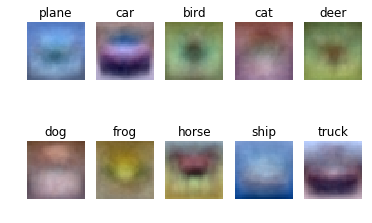

In [20]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

In [21]:
num_test = np.arange(240).reshape((4,4,3,5))
print(num_test.shape)

(4, 4, 3, 5)


In [23]:
num_test[:,:,:,2].squeeze()

array([[[  2,   7,  12],
        [ 17,  22,  27],
        [ 32,  37,  42],
        [ 47,  52,  57]],

       [[ 62,  67,  72],
        [ 77,  82,  87],
        [ 92,  97, 102],
        [107, 112, 117]],

       [[122, 127, 132],
        [137, 142, 147],
        [152, 157, 162],
        [167, 172, 177]],

       [[182, 187, 192],
        [197, 202, 207],
        [212, 217, 222],
        [227, 232, 237]]])